In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


2025-07-07 14:46:34.003101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751899594.209078      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751899594.272577      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_dir = '/kaggle/input/potholes-classification-2/train'
test_dir = '/kaggle/input/potholes-classification-2/test'
valid_dir = '/kaggle/input/potholes-classification-2/valid'


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define training ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define validation/test ImageDataGenerator
test_valid_datagen = ImageDataGenerator(rescale=1./255)


In [4]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)

valid_generator = test_valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)

test_generator = test_valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Updated to 224x224
    batch_size=32,
    class_mode='binary'
)


Found 14213 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [28]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load DenseNet201 without the fully connected layers (top)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the DenseNet201 layers initially
for layer in base_model.layers:
    layer.trainable = False

    
# Add custom layers on top of DenseNet201
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (pothole vs no pothole)

# Define the final model
model = Model(inputs=base_model.input, outputs=x)

from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 30,364,481 (115.83 MB)

 Trainable params: 12,042,497 (45.94 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 291s 544ms/step - accuracy: 0.7648 - loss: 1.7614 - val_accuracy: 0.8700 - val_loss: 0.2075
Epoch 2/20
  1/444 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.8125 - loss: 0.2302

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8125 - loss: 0.2302 - val_accuracy: 0.8708 - val_loss: 0.2075
Epoch 3/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 198s 445ms/step - accuracy: 0.8225 - loss: 0.3535 - val_accuracy: 0.9296 - val_loss: 0.1715
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8438 - loss: 0.2557 - val_accuracy: 0.9325 - val_loss: 0.1684
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 199s 448ms/step - accuracy: 0.8278 - loss: 0.3426 - val_accuracy: 0.9067 - val_loss: 0.1932
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9062 - loss: 0.3784 - val_accuracy: 0.9079 - val_loss: 0.1907
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 199s 449ms/step - accuracy: 0.8514 - loss: 0.3009 - val_accuracy: 0.9333 - val_loss: 0.1456
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9062 - loss: 0.2276 - val_accuracy: 0.9350 - val_loss: 0.1437
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 197s 442ms/step - accuracy: 0.8651 - loss: 0.2928 - val_a

In [30]:
# Unfreeze the last few layers of DenseNet201 (e.g., the last 20 layers)
for layer in base_model.layers[-20:]:
    layer.trainable = True  # Unfreeze the last 30 layers (adjust as necessary)

# Recompile the model after unfreezing layers
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model for more epochs
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Fine-tune for more epochs
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 303s 560ms/step - accuracy: 0.8539 - loss: 0.3201 - val_accuracy: 0.9379 - val_loss: 0.1436
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8750 - loss: 0.3701 - val_accuracy: 0.9375 - val_loss: 0.1453
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 202s 455ms/step - accuracy: 0.8760 - loss: 0.2737 - val_accuracy: 0.9371 - val_loss: 0.1456
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7500 - loss: 0.3122 - val_accuracy: 0.9371 - val_loss: 0.1460
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 200s 451ms/step - accuracy: 0.8854 - loss: 0.2617 - val_accuracy: 0.9383 - val_loss: 0.1432
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7500 - loss: 0.2945 - val_accuracy: 0.9388 - val_loss: 0.1425
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 200s 450ms/step - accuracy: 0.8811 - loss: 0.2605 - val_accuracy: 0.9396 - val_loss: 0.1407
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9375 - loss: 0.

In [31]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9463 - loss: 0.1548
Test Loss: 0.17274028062820435
Test Accuracy: 0.9366554021835327


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


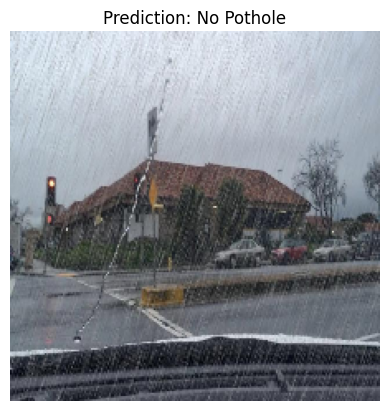

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to the image you want to predict
img_path = '/kaggle/input/potholes-classification-2/test/Not Pothole/05ca0197-6c0b4628_jpg.rf.bdf262f0a27a523e93e3a9f2a78490cc.jpg'  # Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert image to array
img_array = img_array / 255.0  # Rescale the image to match the model's input
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(img_array)

# Show the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.title("Prediction: Pothole" if prediction[0] > 0.5 else "Prediction: No Pothole")
plt.show()

In [34]:
# Ground truth for the image (True Label)
true_label = 1  # If the image is a pothole, set it to 1, otherwise 0

# Compare predicted label with the true label
prediction = model.predict(img_array)
predicted_label = 1 if prediction[0] > 0.5 else 0  # If prediction > 0.5, it's Pothole (1), otherwise No Pothole (0)

# Check if the prediction is correct
correct = (predicted_label == true_label)
accuracy = (correct * 100)  # 100% if correct, 0% if incorrect

print(f"Prediction: {'Pothole' if predicted_label == 1 else 'No Pothole'}")
print(f"Accuracy: {accuracy}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction: No Pothole
Accuracy: 0%


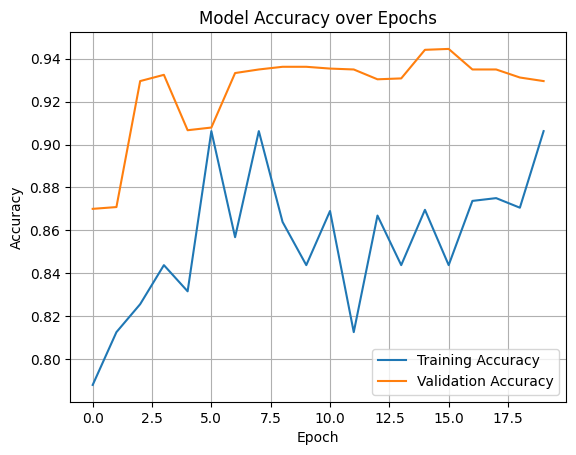

In [36]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [37]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_generator.samples // self.test_generator.batch_size,
            verbose=0
        )
        self.test_accuracies.append(acc)
        print(f"\nTest accuracy after epoch {epoch+1}: {acc:.4f}")


In [38]:
# Initialize the callback
test_callback = TestAccuracyCallback(test_generator)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[test_callback]
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8784 - loss: 0.2613
Test accuracy after epoch 1: 0.9375
444/444 ━━━━━━━━━━━━━━━━━━━━ 221s 497ms/step - accuracy: 0.8784 - loss: 0.2612 - val_accuracy: 0.9404 - val_loss: 0.1360
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.8750 - loss: 0.3308
Test accuracy after epoch 2: 0.9375
444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.8750 - loss: 0.3308 - val_accuracy: 0.9404 - val_loss: 0.1378
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8810 - loss: 0.2596
Test accuracy after epoch 3: 0.9375
444/444 ━━━━━━━━━━━━━━━━━━━━ 207s 466ms/step - accuracy: 0.8810 - loss: 0.2596 - val_accuracy: 0.9425 - val_loss: 0.1367
Epoch 4/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.8438 - loss: 0.2770
Test accuracy after epoch 4: 0.9375
444/444 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.8438 - loss: 0.2770 - val_accuracy: 0.9417 - val_loss: 0.1375
Epoch 5/10
444/444 ━━━

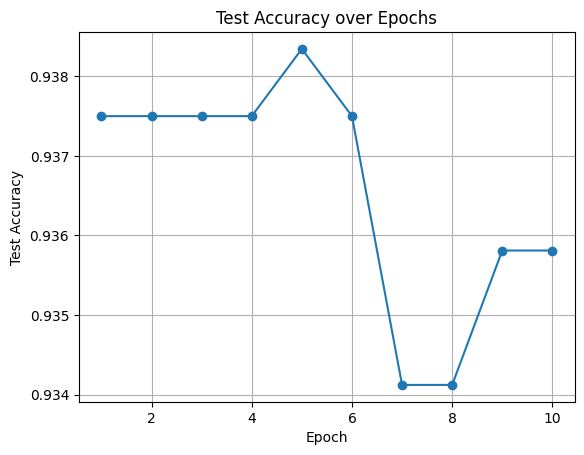

In [39]:
# Plot test accuracy per epoch
plt.plot(range(1, len(test_callback.test_accuracies) + 1), test_callback.test_accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()


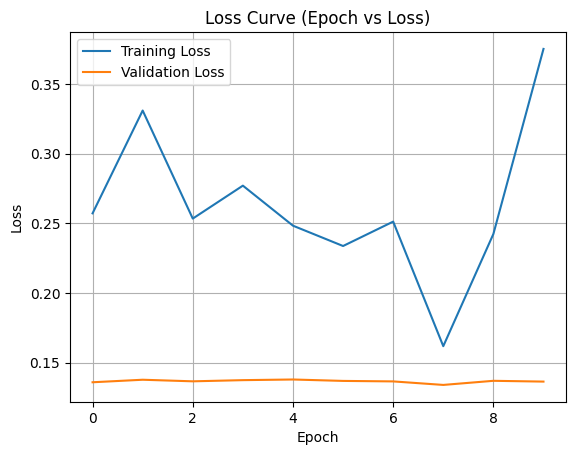

In [40]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Curve (Epoch vs Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reset the generator to start from the beginning
train_generator.reset()

# Initialize lists for true labels and predictions
train_labels = []
train_predictions = []

# Iterate through the batches
for i in range(train_generator.samples // train_generator.batch_size):
    images, labels = next(train_generator)  # Get batch
    predictions = model.predict(images, verbose=0)  # Predict batch
    train_labels.extend(labels)
    train_predictions.extend(np.round(predictions))  # Round to 0 or 1

# Convert to numpy arrays
train_labels = np.array(train_labels).astype(int)
train_predictions = np.array(train_predictions).astype(int)

# Generate and print confusion matrix
cm_train = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix for Training Data:")
print(cm_train)


Confusion Matrix for Training Data:
[[6538  355]
 [ 730 6585]]


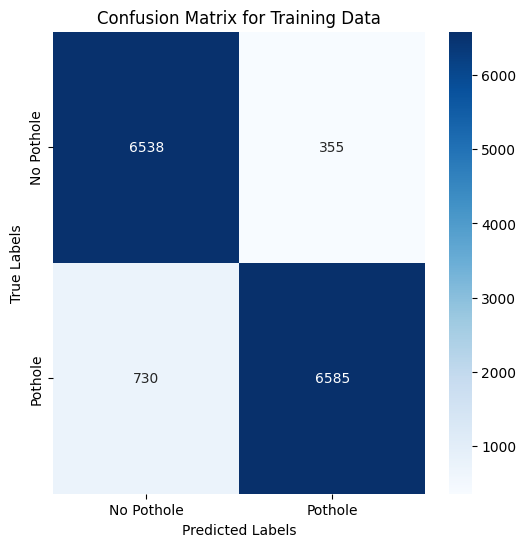

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training data
cm_train = confusion_matrix(train_labels, train_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pothole', 'Pothole'], yticklabels=['No Pothole', 'Pothole'])
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming train_labels and train_predictions are already defined (from previous steps)

# Calculate Accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(train_labels, train_predictions)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(train_labels, train_predictions)
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(train_labels, train_predictions)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9236
Precision: 0.9488
Recall: 0.9002
F1 Score: 0.9239


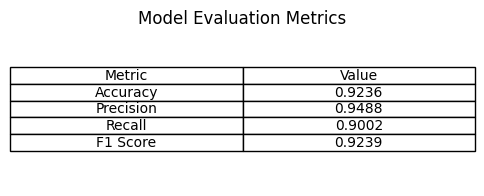

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
f1 = f1_score(train_labels, train_predictions)

# Create the data for the table
metrics = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}']
]

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 2))  # Set size of the figure
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

# Display the table
plt.title("Model Evaluation Metrics")
plt.show()


In [47]:
# Save the model
model.save('DenseNet201.h5')  # Save as a .h5 file

print("Model saved successfully!")


Model saved successfully!


In [48]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /kaggle/working
